# AI vs. Human
Assuming the same image segmenter and models, results are predetermined for labeling.
Thus, we can easily compare on an image-to-image basis the assigned Region and its ML-assigned label ("Labels") and compare against the human assigned labels ("Labels_RC" for Rachel, can change based on person)

In [1]:
# Imports
import sys
sys.path.append("..")
from Utility.segmentation_utils import *
import Utility.model_utils as mu
import matplotlib.pyplot as plt
import os
import time

In [2]:
### DEFINE VARIABLES OF INTEREST HERE ###

# vvv Four values to change vvv
# img_folder : Exact path to folder of interest (typically in "../Images")
# image_name : Exact name (not path!) of the image within the folder we want to look at
# csv_path   : Exact path to results csv file associated with runtime parameters of interest (NOTE: may be easier to re-run model as needed)
# id_human   : Identification of who is classifying to make things easier for the user

## Define folder path of interest, image of interest, and csv path for folder of interest
# Note: Can maybe automate this, but name changing makes it difficult
img_folder = "../Images/Organized images 20230613/L-3_nM-3_au10_mixing-T_oven-T_embed-Ag"
image_name = "L-3_nM-3_au10_mixing-T_oven-T_embed-Ag_01.tif"
csv_path = "../Results/Organized images 20230613_Results/L-3_nM-3_au10_mixing-T_oven-T_embed-Ag_edge-darkbright_thresh-ensemble.csv"
id_human = "RC"

# Runtime settings to compare against
edge = "darkbright"
thresh = "ensemble"

# Derive variables
img_path = os.path.join(img_folder,image_name)
save_folder = f"ai_human_labeling/{img_folder.split('/')[-1]}"
os.makedirs(save_folder,exist_ok=True)

# Check that the files exist. If an assert fails, check the naming!
assert(os.path.exists(img_folder))
assert(os.path.exists(img_path))
assert(os.path.exists(csv_path))

In [3]:
# Get the already processed csv
df = pd.read_csv(csv_path)
img_logical = df.Filename.str.contains(image_name)
df_img = df[img_logical]

IS = ImageSegmenter(img_path,threshold_mode=thresh,edge_modification=edge)

# Set index to be Region based
df_IS = IS.df.set_index("Region")
df_img = df_img.set_index("Region")

# Define label_dict
label_dict = {"C":"Crystal",
              "MC":"Multiple Crystal",
              "I":"Incomplete",
              "P":"Poorly Segmented"
              }

/home/jacob/anaconda3/envs/colloidal_crystal_env/lib/python3.9/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.0 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jacob/anaconda3/envs/colloidal_crystal_env/lib/python3.9/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.0 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(3, 3)


/home/jacob/Desktop/Academics/Mirkin/colloidal_crystal_ML/Workbooks/../Utility/segmentation_utils.py:432: RuntimeWarning: divide by zero encountered in divide
  clusters['major_axis_length/minor_axis_length'] = clusters['major_axis_length']/clusters['minor_axis_length']
/home/jacob/Desktop/Academics/Mirkin/colloidal_crystal_ML/Workbooks/../Utility/segmentation_utils.py:434: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/minor_axis_length'] = clusters['perimeter']/clusters['minor_axis_length']


In [4]:
## TESTING CELL: Ensure that the regions being observed are commensurate w/ regions previously acquired
df_region_list = df_img.index.to_list()
region_list = df_IS.index.to_list()

comp_key = ['area','equivalent_diameter','major_axis_length','minor_axis_length']
comp_check_arr = []
for reg_id in region_list:
    try:
        row_1 = df_IS.loc[reg_id][comp_key].to_dict()
        row_2 = df_img.loc[reg_id][comp_key].to_dict()
    except:
        print(f"Region issue: {reg_id}")
        continue
    res = True
    for key,_ in row_1.items():
        if np.round(row_1[key],2) != np.round(row_2[key],2):
            print(row_1[key],row_2[key])
            res = False
    comp_check_arr.append(res)

# If this fails, the ML csv *does not* line-up with the current IS's parameters
assert(False not in np.unique(comp_check_arr))

Region issue: 10
Region issue: 52


In [5]:
## Reading variables
# These are defined here in case cells past this one die or are exited
# IF THIS IS REFRESHED, PROGRESS BELOW IS LOST
human_label_dict = {}

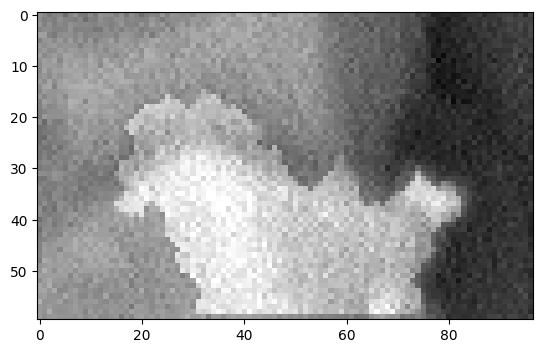

Region: 141
140/140: Crystal
Label (C, MC, I, P) or
Move (Index_int)


In [6]:
## Analysis Cell
region_img_list = list(IS.region_dict.items())

ii = 0
while ii < len(region_img_list):
    key,img = region_img_list[ii]
    # Visualize
    clear_output(wait=False)
    plt.imshow(img)
    plt.show()
    try:
        model_thinks = df_img.loc[key].Labels
    except:
        model_thinks = "Doesn't exist"
    
    # Information about Image
    print(f"Region: {key}")
    print(f'{ii}/{len(region_img_list)-1}: {model_thinks}')
    print('Label (C, MC, I, P) or\nMove (Index_int)')

    # Interaction Point
    time.sleep(.1)
    human_input = input('Input: ')
    check_label = label_dict.get(human_input,None)
    if check_label:
        human_label_dict[key] = check_label
        ii += 1
    elif human_input.isdigit():
        ii = int(human_input)

In [9]:
# Attach labels to everything
df_img[f"{id_human}_Labels"] = pd.DataFrame(human_label_dict.values(),index=human_label_dict.keys())

In [10]:
save_name = f'{img_path.split("/")[-1].split(".")[-2]}_Label-{id_human}.csv'
save_path = os.path.join(save_folder,save_name)
df_img.to_csv(save_name)